# Exercise 3

## Occupancy grid mapping

The aim of this assignment is to implement a 2D occupancy grid mapping algorithm as described in the lecture. We provide data recorded by a robot using a 2D laser scanner in an indoor environment. 

The raw data is arranged in the following manner:

- `poses.data`: contains the **known** robot poses as it moves around the environment. Each line corresponds to the pose of the robot at a time instant

- `ranges.data`: contains 2d laser range measurements recorded by the robot. Each line corresponds to the range measurements taken from the corresponding robot poses.

---

### Log odds to probability

The occupancy calculations are usually performed using the log odds. We will need to convert between log odds and probabilities in this exercise. Implement the `logodds2prob` and `prob2logodds` functions. Verify that the conversion functions are correct for some test input. **[2.0]**

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import bresenham as bh
import math

def plot_gridmap(gridmap):
    plt.figure()
    plt.imshow(gridmap, cmap='Greys',vmin=0, vmax=1)
    
def init_gridmap(size, res):
    gridmap = np.zeros([int(np.ceil(size/res)), int(np.ceil(size/res))])
    return gridmap

def world2map(pose, gridmap, map_res):
    origin = np.array(gridmap.shape) / 2
    new_pose = np.zeros(2)  #tuple needs parentheses or just use integer
    new_pose[0] = np.round(pose[0] / map_res) + origin[0]
    new_pose[1] = np.round(pose[1] / map_res) + origin[1]
    return new_pose.astype(int)

def v2t(pose):
    c = np.cos(pose[2])
    s = np.sin(pose[2])
    tr = np.array([[c, -s, pose[0]], [s, c, pose[1]], [0, 0, 1]])
    return tr

def ranges2points(ranges):
    # laser properties
    start_angle = -1.5708
    angular_res = 0.0087270
    max_range = 30
    # rays within range
    num_beams = ranges.shape[0]
    idx = (ranges < max_range) & (ranges > 0)
    # 2D points
    angles = np.linspace(start_angle, start_angle + (num_beams*angular_res), num_beams)[idx]
    points = np.array([np.multiply(ranges[idx], np.cos(angles)), np.multiply(ranges[idx], np.sin(angles))])
    # homogeneous points
    points_hom = np.append(points, np.ones((1, points.shape[1])), axis=0)
    return points_hom

def ranges2cells(r_ranges, w_pose, gridmap, map_res):
    # ranges to points
    r_points = ranges2points(r_ranges)
    w_P = v2t(w_pose)
    w_points = np.matmul(w_P, r_points)
    
    # Convert to map frame (handle multiple points)
    origin = np.array(gridmap.shape) / 2
    num_points = w_points.shape[1]
    m_points = np.zeros((2, num_points))
    m_points[0, :] = np.round(w_points[0, :] / map_res) + origin[0]
    m_points[1, :] = np.round(w_points[1, :] / map_res) + origin[1]
    m_points = m_points.astype(int)
    
    return m_points

def poses2cells(w_pose, gridmap, map_res):
    # covert to map frame
    m_pose = world2map(w_pose, gridmap, map_res)
    return m_pose  

def bresenham(x0, y0, x1, y1):
    l = np.array(list(bh.bresenham(x0, y0, x1, y1)))
    return l
    
def prob2logodds(p):
    if p!=0 and p!=1:
        odds=p/(1-p)
    return math.log(odds)
    
def logodds2prob(l):
    p=1/(1+math.exp(-l))
    return p
    
def inv_sensor_model(cell, endpoint, prob_occ, prob_free):
    #cell:(i,j) 
    #endpoint:endpoint coordinates where laser hits
    #prob_occ=0.9
    #prob_free=0.35

    prob_prior=0.5
    dist = np.sqrt((cell[0] - endpoint[0])**2 + (cell[1] - endpoint[1])**2)
    #if cell is in a certain threshold proximity to the endpoint, it is occupied
    if dist<0.1:
        return prob_occ
    else: #its beyond range
        return prob_free
    

def grid_mapping_with_known_poses(ranges_raw, poses_raw, occ_gridmap, map_res, prob_occ, prob_free, prior):
    for t in range(len(poses_raw)):
        pose=poses_raw[t]
        ranges=ranges_raw[t]

        cell=poses2cells(pose,occ_gridmap,map_res)
        endpoint_cells=ranges2cells(ranges,pose,occ_gridmap,map_res)

        for endpoint in endpoint_cells:
            cells_in_ray=bresenham(cell[0],cell[1],endpoint[0],endpoint[1])
            
            for cell in cells_in_ray:
                i,j=cell[0],cell[1]

                if 0<=i<=occ_gridmap.shape[0] and 0<=j<=occ_gridmap.shape[1]:
                    #applying inverse sensor model
                    prob=inv_sensor_model((i,j),(endpoint[0],endpoint[1]),0.9,0.35)

                    #we need to update the logodds in occupancy grid map
                    occ_gridmap[i,j]+=prob2logodds(prob)-prob2logodds(prior)

    return occ_gridmap



In [6]:
prob=0.43

logodds=prob2logodds(prob)
print(logodds)

prob=logodds2prob(logodds)
print(prob)


-0.2818511521409879
0.43


---
### Inverse sensor model

The occupancy grid mapping relies on as inverse sensor model to update the occupancy of a cell in the grid. For this exercise, we consider a simple sensor model, where the occupancy of cell $m_i$ is $P_{occ}$ if the measurement $z_t$ falls in that cell, otherwise the occupancy is $P_{free}$. 

However, if the cell $m_i$ is not in the perception field, the occupancy will be $P_{prior}$.

Use the  following probabilities in the implementation:
$$P_{occ} = 0.9, P_{free} = 0.35, P_{prior} = 0.5 $$

Implement the inverse sensor model function and verify that it is correct for some test input. **[2.0]**

In [ ]:
prob=inv_sensor_model((5.02,7.01),(5,7),0.9,0.35)
print(prob)

#basically we got that ourcell is close to the endpoint. so it must be occupied

0.9


---
### Occupancy grid mapping algorithm:

Implement the occupancy grid mapping algorithm as described in lecture slides. 

We provide some functions to make the implemntation easier.

- `ranges2cells` converts the raw measurements acquired by the robot (*ranges_raw*) into the correspoding cells of the gridmap.
- `poses2cells` converts the raw poses of the robot (*poses_raw*) into the correspoding cells of the gridmap.
- `bresenham` returns all the cells along a straigh line between two points in the gridmap.

Other parameters you may need in the implemntation are provided below.

Implement the `grid_mapping_with_known_poses` functionn and compute the resulting occupancy grid map using all the measurements provided in the data.

Plot the final occupancy gridmap using the `plot_gridmap` function. **[6.0]**


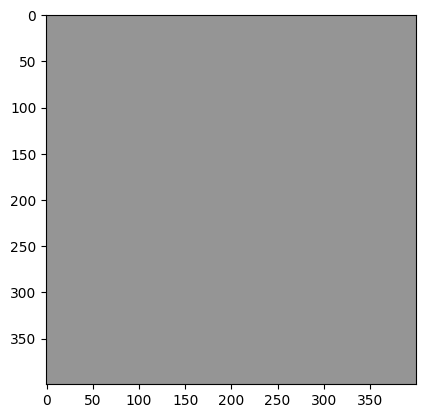

In [23]:
map_size = 100
map_res = 0.25

prior = 0.50
prob_occ = 0.90
prob_free = 0.35

# load data
ranges_raw = np.loadtxt("ranges.data", delimiter=',', dtype='float')
poses_raw = np.loadtxt("poses.data", delimiter=',', dtype='float')

# initialize gridmap
occ_gridmap = init_gridmap(map_size, map_res)+prior
plot_gridmap(occ_gridmap)




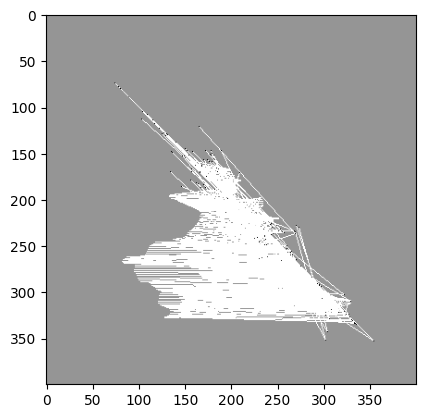

In [24]:
res_gridmap=grid_mapping_with_known_poses(ranges_raw,poses_raw,occ_gridmap,map_res,0.9,0.35,0.5)

plot_gridmap(res_gridmap)